In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from torchmetrics.classification.calibration_error import MulticlassCalibrationError
from torchmetrics.functional.classification.calibration_error import _binning_bucketize
import torch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from expected_cost.ec import average_cost, CostMatrix

from hm4.labelling import CLASS_NAMES
import hm4.labelling as labelling
from hm4.expected_cost import COST_ARRAY
from crism_ml.lab import relabel, ALIASES_TRAIN

In [ ]:
# data paths for the data preprocessed as by Dhoundiyal et al. (2025) and aggregated.
# See scripts/dhoundiyal_benchmark for the preprocessing scripts.
TRAIN_DATA_PATH = #
TEST_DATA_PATH = #

xy_train = pd.read_json(TRAIN_DATA_PATH)
xy_test = pd.read_json(TEST_DATA_PATH)

/tmp/ipykernel_1951640/3662977966.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  xy_train = pd.read_json(os.path.join(DATA_DIR, "train_data_v1.json"))
/tmp/ipykernel_1951640/3662977966.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  xy_train = pd.read_json(os.path.join(DATA_DIR, "train_data_v1.json"))
/tmp/ipykernel_1951640/3662977966.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be pars

In [21]:
x_train = xy_train.iloc[:, :-3].to_numpy()
x_test = xy_test.iloc[:, :-3].to_numpy()

y_train = xy_train["Pixel_Class"].to_numpy()
y_test = xy_test["Pixel_Class"].to_numpy()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1024, criterion="entropy", n_jobs=-1)
rf_model.fit(x_train, y_train)

In [24]:
y_pred = rf_model.predict(x_test)

In [25]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7023109450290097


In [26]:
cost_matrix = CostMatrix(COST_ARRAY)
priors = np.full(38, 1 / 38) # uniform priors

In [27]:
# Calculate performance metrics

true_unique_classes = np.unique(y_test)
predicted_unique_classes = np.unique(y_pred)
classes_to_calculate_f1 = np.unique(np.concatenate((true_unique_classes, predicted_unique_classes)))
string_labels = np.array([CLASS_NAMES[int(obs_class)] for obs_class in classes_to_calculate_f1])

report = classification_report(y_test, y_pred, output_dict=True)
expected_cost = average_cost(y_test, y_pred, cost_matrix, priors)


In [28]:
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {expected_cost}")

Accuracy: 0.7023109450290097
Macro F1: 0.4981052063522465
Weighted F1: 0.7505403226093976
Precision: 0.4975057676279251
Recall: 0.6859597922487635
Expected Cost: 0.32587068555467397


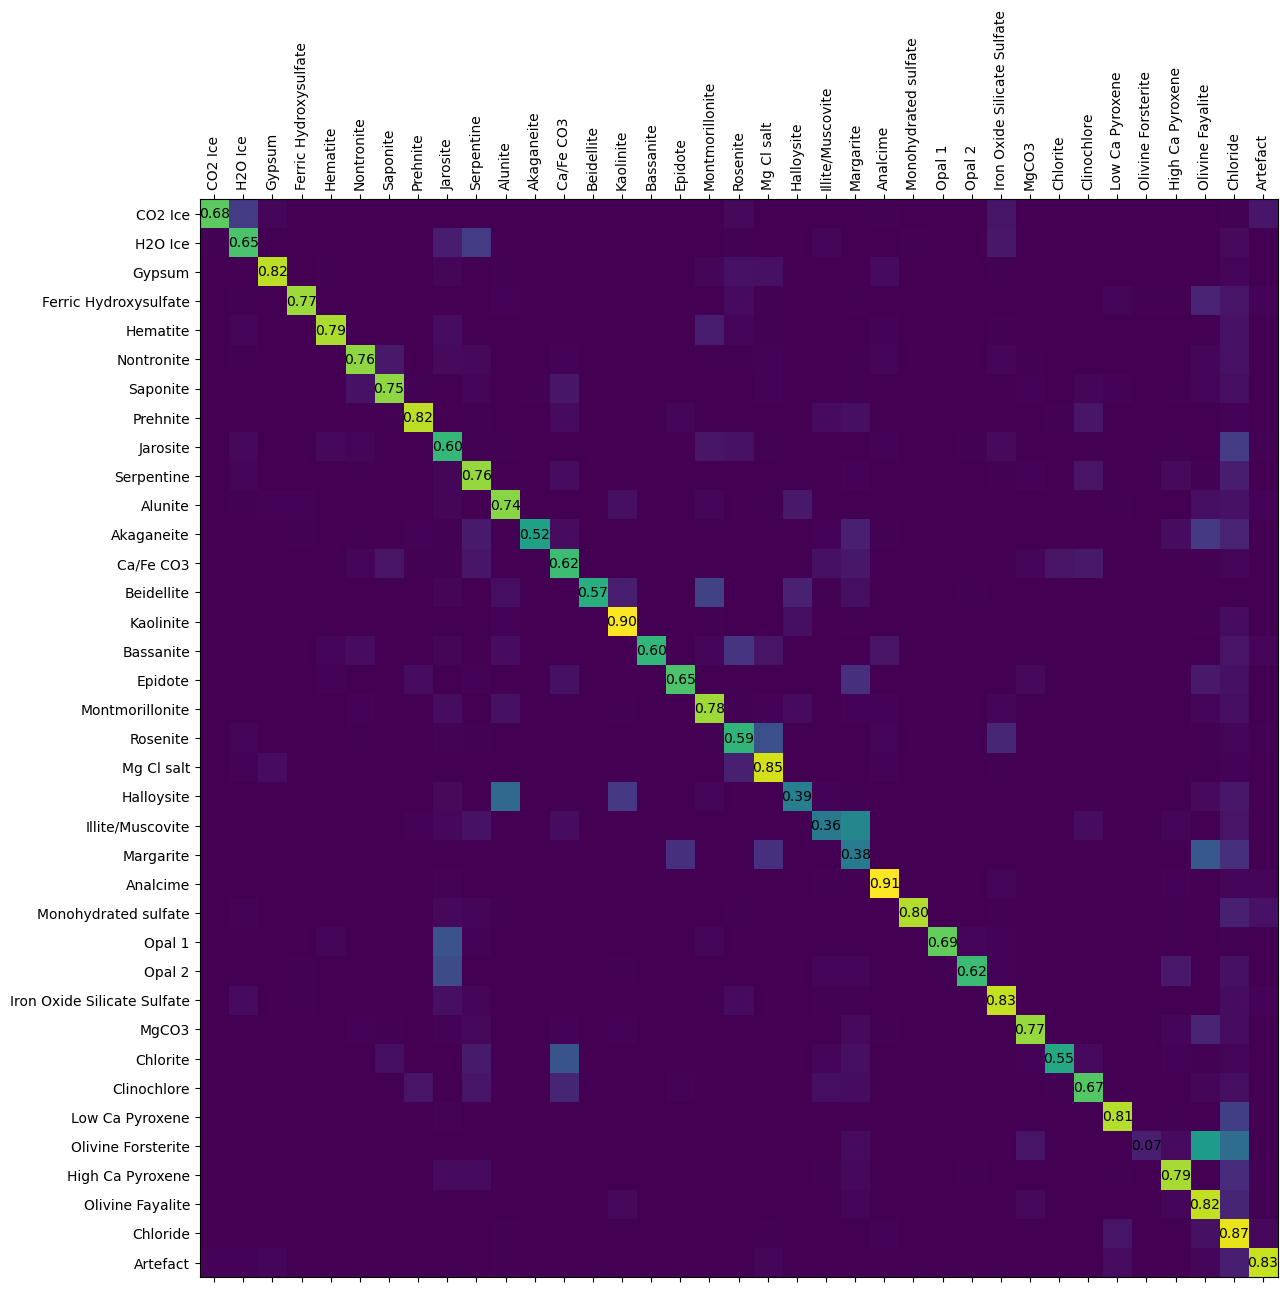

In [29]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm, cmap='viridis')
# add class labels to x and y axes
ax.set_xticks(range(len(string_labels)))
ax.set_yticks(range(len(string_labels)))
ax.set_xticklabels(string_labels, rotation=90)
ax.set_yticklabels(string_labels)
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(string_labels)):
    for j in range(len(string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')


In [ ]:
# Write out the trained model to a pickle file
with open("platt_retrained_rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f, protocol=5)

In [31]:
# first need to map the labels back to the FULL_NAMES as listed in crism_ml.lab
y_true_relabelled = labelling.change_pixel_label(y_test, in_val=21, out_val=38)
y_pred_relabelled = labelling.change_pixel_label(y_pred, in_val=21, out_val=38)

y_true_relabelled = labelling.make_array_zero_indexed(y_true_relabelled, forwards=False)
y_pred_relabelled = labelling.make_array_zero_indexed(y_pred_relabelled, forwards=False)


In [32]:
y_true_relabelled = relabel(y_true_relabelled, ALIASES_TRAIN)
y_pred_relabelled = relabel(y_pred_relabelled, ALIASES_TRAIN)

In [33]:
# for expected cost the labels need to be zero indexed, otherwise the highest class number will be out of range
y_true_relabelled_zero = labelling.make_array_zero_indexed(y_true_relabelled, forwards=True)
y_pred_relabelled_zero = labelling.make_array_zero_indexed(y_pred_relabelled, forwards=True)

In [34]:
super_class_report = classification_report(y_pred_relabelled, y_true_relabelled, output_dict=True)
super_class_expected_cost = average_cost(y_true_relabelled_zero, y_pred_relabelled_zero, cost_matrix, priors)
print(f"Super class accuracy: {super_class_report['accuracy']}")
print(f"Super class macro F1: {super_class_report['macro avg']['f1-score']}")
print(f"Super class weighted F1: {super_class_report['weighted avg']['f1-score']}")
print(f"Super class precision: {super_class_report['macro avg']['precision']}")
print(f"Super class recall: {super_class_report['macro avg']['recall']}")
print(f"Super class expected cost: {super_class_expected_cost}")

Super class accuracy: 0.7175966171698299
Super class macro F1: 0.5299058438666367
Super class weighted F1: 0.6690028637158836
Super class precision: 0.7314740365757788
Super class recall: 0.5239433392827164
Super class expected cost: 0.25578718922366356


Confidence Calibration Assessment

In [35]:
pred_probs = rf_model.predict_proba(x_test)

In [36]:
accuracies = y_pred == y_test
accuracies = torch.tensor(accuracies)
bin_bounds = torch.linspace(0, 1, 11) # ten bins
confidence = torch.tensor(pred_probs.max(axis=1))
acc_bin, conf_bin, prop_bin = _binning_bucketize(confidence, accuracies, bin_bounds) # bucketize the probs/confs, the accuracies, and the proportion of data in each bin


In [ ]:
torch.save(acc_bin, "dhoundiyal_test_accuracy_vals.pt")
torch.save(conf_bin, "dhoundiyal_test_confidence_vals.pt")
torch.save(pred_probs, "dhoundiual_test_pred_probs.pt")

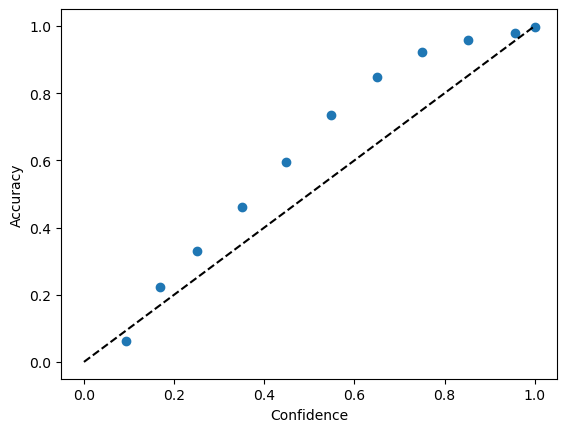

In [37]:
fig, ax = plt.subplots()
ax.scatter(conf_bin, acc_bin)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
# add a diagonal line for reference
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

In [38]:
conf_bin

tensor([0.0939, 0.1676, 0.2517, 0.3497, 0.4489, 0.5484, 0.6498, 0.7508, 0.8516,
        0.9554, 1.0000], dtype=torch.float64)

In [39]:
print(f"Mean confidnece: {confidence.mean()}, minimum confidence {confidence.min()}, maximum confidence {confidence.max()}")

Mean confidnece: 0.5864185672294473, minimum confidence 0.0791015625, maximum confidence 1.0


In [40]:
pred_probs.shape

(508450, 37)

In [41]:
calibration_metric = MulticlassCalibrationError(num_classes=37, n_bins=10)
calibration_metric.update(torch.Tensor(pred_probs), torch.Tensor(y_test))
ece = calibration_metric.compute()
print(f"ECE: {ece}")

ECE: 0.12415327876806259
